In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy
from scipy.signal import stft,istft
import IPython.display as ipd
import torch 
import torch.nn as nn
import h5py  
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.optim as optim
import random
import os
from mir_eval.separation import bss_eval_sources
import re
import scipy.io.wavfile as wav
from glob import glob
import pandas as pd
from sklearn.linear_model import LinearRegression


## Séparation de sources, projet


In [2]:
fe1, data1 = scipy.io.wavfile.read("train_small/0000/mix_snr_3.wav")
print("Signal brut : mix_snr_3.wav")
display(ipd.Audio(data1, rate=fe1))

fe2, data2 = scipy.io.wavfile.read("train_small/0000/noise.wav")
print("Bruit : noise.wav")
display(ipd.Audio(data2, rate=fe2))

fe3, data3 = scipy.io.wavfile.read("train_small/0000/voice.wav")
print("Voix : voice.wav")
display(ipd.Audio(data3, rate=fe3))

Signal brut : mix_snr_3.wav


Bruit : noise.wav


Voix : voice.wav


In [3]:
fe1, data1 = scipy.io.wavfile.read("train_small/0002/mix_snr_-2.wav")
print("Signal brut : mix_snr_-2.wav")
display(ipd.Audio(data1, rate=fe1))

fe2, data2 = scipy.io.wavfile.read("train_small/0000/noise.wav")
print("Bruit : noise.wav")
display(ipd.Audio(data2, rate=fe2))

fe3, data3 = scipy.io.wavfile.read("train_small/0000/voice.wav")
print("Voix: voice.wav")
display(ipd.Audio(data3, rate=fe3))


Signal brut : mix_snr_-2.wav


Bruit : noise.wav


Voix: voice.wav


La première chose que j'aimerais voir c'est la distribution des SNR sur l'ensemble des données d'entraînement et de test, afin de voir si les distributions de SNR sont similaires.

In [4]:
dossier_principal = "train"
pattern = re.compile(r"mix_snr_([+-]?\d+)")
snr_values = []

for sous_dossier in os.listdir(dossier_principal):
    chemin_sous_dossier = os.path.join(dossier_principal, sous_dossier)
    if os.path.isdir(chemin_sous_dossier):  
        fichiers = os.listdir(chemin_sous_dossier)
        for fichier in fichiers:
            match = pattern.search(fichier)
            if match:
                snr_value = int(match.group(1))
                snr_values.append(snr_value)

df_snr = pd.DataFrame(snr_values, columns=["SNR"])

df_snr_counts = df_snr["SNR"].value_counts().reset_index()
df_snr_counts.columns = ["SNR", "Occurrence"]
df_snr_counts = df_snr_counts.sort_values(by="SNR", ascending=True).reset_index(drop=True)

print(df_snr_counts)


   SNR  Occurrence
0   -4         516
1   -3         450
2   -2         507
3   -1         506
4    0        1001
5    1         506
6    2         485
7    3         509
8    4         520


In [5]:
dossier_principal = "test"
pattern = re.compile(r"mix_snr_([+-]?\d+)")
snr_values = []

for sous_dossier in os.listdir(dossier_principal):
    chemin_sous_dossier = os.path.join(dossier_principal, sous_dossier)
    if os.path.isdir(chemin_sous_dossier):  
        fichiers = os.listdir(chemin_sous_dossier)
        for fichier in fichiers:
            match = pattern.search(fichier)
            if match:
                snr_value = int(match.group(1))
                snr_values.append(snr_value)

df_snr = pd.DataFrame(snr_values, columns=["SNR"])

df_snr_counts = df_snr["SNR"].value_counts().reset_index()
df_snr_counts.columns = ["SNR", "Occurrence"]
df_snr_counts = df_snr_counts.sort_values(by="SNR", ascending=True).reset_index(drop=True)

print(df_snr_counts)


   SNR  Occurrence
0   -4         206
1   -3         207
2   -2         205
3   -1         201
4    0         395
5    1         209
6    2         171
7    3         206
8    4         200


La structure est similaire pour les ensembles de train et de test.

## Deep U-Net convolutional networks
L'objectif est de mettre en place l'architecture proposée par l'article "SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORKS" dans le cadre de la séparation chanteur-instrumental pour notre problème de séparation de sources. Dans un premier temps, on va essayer de quantifier les résultats qu'on obtient via les paramètres de l'article puis on essaiera de jouer avec certains paramètres pour améliorer les performances. On réalise l'apprentissage sur le spectrogramme normalisé. Pour coller avec l'article (au niveau des dimensions de l'architecture), on va récupérer seulement les 128 données temporelles du spectrogramme, faisant cela, on ne perd pas de structure car le bruit reste constant au sein d'un même enregistrement, on diminue simplement la taille des données. 

In [6]:
def to_spectrogram(data, fe):
    data = data[:64897]
    nb = 1022
    nperseg = nb  
    noverlap = nb // 2 
    f, tfct, Zxx = stft(data, fs=fe, nperseg=nperseg, nfft=nb, noverlap=noverlap, window='hamming')
    Zxx_magnitude = np.abs(Zxx)**2
    Zxx_normalized = (Zxx_magnitude - np.min(Zxx_magnitude)) / (np.max(Zxx_magnitude)-np.min(Zxx_magnitude))
    return Zxx_normalized


In [7]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dir):
        self.dir = dir
        self.files = []
        
        for subfolder in os.listdir(dir):
            subfolder_path = os.path.join(dir, subfolder)
            if os.path.isdir(subfolder_path):
                mix = glob(os.path.join(subfolder_path, "mix*.wav"))
                noise = glob(os.path.join(subfolder_path, "noise.wav"))
                voice = glob(os.path.join(subfolder_path, "voice.wav"))
                
                if mix and noise and voice:
                    self.files.append((mix[0], noise[0], voice[0]))
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        mix_path, noise_path, voice_path = self.files[idx]
        sample_rate, waveform = scipy.io.wavfile.read(mix_path)  
        #convertir en spectogramme
        spectrogram = to_spectrogram(waveform, fe=sample_rate)
        return torch.tensor(spectrogram), mix_path, noise_path, voice_path


In [8]:
dir_path = 'train/'  

dataset = MyDataset(dir=dir_path)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

for batch_idx, (spectrograms, mix_path, noise_path, voice_path) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Spectrogrammes shape: {spectrograms.shape}")    
    print(f"Exemple de mix_path: {mix_path[0]}")
    print(f"Exemple de noise_path: {noise_path[0]}")
    print(f"Exemple de voice_path: {voice_path[0]}")
    
    if batch_idx >= 2: 
        break


Batch 1:
Spectrogrammes shape: torch.Size([4, 512, 128])
Exemple de mix_path: train/0738\mix_snr_-3.wav
Exemple de noise_path: train/0738\noise.wav
Exemple de voice_path: train/0738\voice.wav
Batch 2:
Spectrogrammes shape: torch.Size([4, 512, 128])
Exemple de mix_path: train/1390\mix_snr_1.wav
Exemple de noise_path: train/1390\noise.wav
Exemple de voice_path: train/1390\voice.wav
Batch 3:
Spectrogrammes shape: torch.Size([4, 512, 128])
Exemple de mix_path: train/4005\mix_snr_3.wav
Exemple de noise_path: train/4005\noise.wav
Exemple de voice_path: train/4005\voice.wav


Pour la baseline de ce modèle qui travaille sur le spectrogramme, on va refaire la baseline de l'article : le modèle U-Net qui sera employé après sans les skips connections.

In [9]:
class baseline_source_separation(nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        #encode
        self.conv1 = nn.Conv2d(1,16,kernel_size=5,stride=2,padding=2)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,kernel_size=5,stride=2,padding=2)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,kernel_size=5,stride=2,padding=2)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64,128,kernel_size=5,stride=2,padding=2)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128,256,kernel_size=5,stride=2,padding=2)
        self.batch_norm5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256,512,kernel_size=5,stride=2,padding=2)
        self.batch_norm6 = nn.BatchNorm2d(512)

        #decode
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm1_d = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout2d(0.5)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm2_d = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(0.5)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm3_d = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout2d(0.5)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm4_d = nn.BatchNorm2d(32)
        self.deconv5 = nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm5_d = nn.BatchNorm2d(16)
        self.deconv6 = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm6_d = nn.BatchNorm2d(1)

        #activation
        self.Lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #encode
        x = self.Lrelu(self.batch_norm1(self.conv1(x)))
        x = self.Lrelu(self.batch_norm2(self.conv2(x)))
        x = self.Lrelu(self.batch_norm3(self.conv3(x)))
        x = self.Lrelu(self.batch_norm4(self.conv4(x)))
        x = self.Lrelu(self.batch_norm5(self.conv5(x)))
        x = self.Lrelu(self.batch_norm6(self.conv6(x)))
        #decode
        x = self.relu(self.batch_norm1_d(self.deconv1(x)))
        x = self.dropout1(x)
        x = self.relu(self.batch_norm2_d(self.deconv2(x)))
        x = self.dropout2(x)
        x = self.relu(self.batch_norm3_d(self.deconv3(x)))
        x = self.dropout3(x)
        x = self.relu(self.batch_norm4_d(self.deconv4(x)))
        x = self.relu(self.batch_norm5_d(self.deconv5(x)))
        x = self.sigmoid(self.batch_norm6_d(self.deconv6(x)))
        return x
    

model = baseline_source_separation()
dummy_input = torch.randn(5,1,512,128)
output = model(dummy_input)
print(output.shape)

torch.Size([5, 1, 512, 128])


On va entraîner ce modèle.

In [63]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        
    def forward(self, mask, input, target):
        return torch.sum(torch.abs((mask*input)-target))

In [11]:
# Paramètres de l'entraînement
num_epochs = 10
batch_size = 25
learning_rate = 0.0001

train = 'train/'  
dataset_train = MyDataset(dir=train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

test = 'test/'
dataset_test = MyDataset(dir=test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

model = baseline_source_separation()
criterion = Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = 'cpu'
model.to(device)

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0

    for batch_idx, (spectrograms, mix_path, noise_path, voice_path) in enumerate(dataloader_train):
        spectrograms = spectrograms.to(device).unsqueeze(1)  

        target_spectrograms = []

        for vp in voice_path:
            sample_rate, waveform_voice = scipy.io.wavfile.read(vp)
            target_spectrogram = to_spectrogram(waveform_voice, fe=sample_rate)
            target_spectrograms.append(target_spectrogram)
        
        target = torch.tensor(target_spectrograms).to(device).unsqueeze(1)

        optimizer.zero_grad()

        #forward pass
        output = model(spectrograms)

        loss = criterion(output, spectrograms, target)

        #backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        #if batch_idx % 50 == 49:
        #    print(f"Epoch [{epoch + 1}/{num_epochs}], Batch {batch_idx + 1}, Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss moyenne: {running_loss / len(dataloader):.4f}")
    
    model.eval() 
    valid_loss = 0.0

    with torch.no_grad():  
        for batch_idx, (spectrograms, mix_path, noise_path, voice_path) in enumerate(dataloader_test):
            spectrograms = spectrograms.to(device).unsqueeze(1)

            target_spectrograms = []

            for vp in voice_path:
                sample_rate, waveform_voice = scipy.io.wavfile.read(vp)
                target_spectrogram = to_spectrogram(waveform_voice, fe=sample_rate)
                target_spectrograms.append(target_spectrogram)

            target = torch.tensor(target_spectrograms).to(device).unsqueeze(1)

            # Forward pass
            output = model(spectrograms)

            # Calcul de la perte
            loss = criterion(output, spectrograms, target)
            valid_loss += loss.item()

        # Moyenne de la perte sur le dataset de test
        valid_loss /= len(dataloader_test)

    print(f"Validation Loss après l'époque {epoch + 1}: {valid_loss:.4f}")


# Sauvegarder le modèle
torch.save(model.state_dict(), "baseline_source_separation.pth")


C:\Users\romai\AppData\Local\Temp\ipykernel_17972\1380383741.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  target = torch.tensor(target_spectrograms).to(device).unsqueeze(1)


Epoch [1/10] - Loss moyenne: 84.7352
Validation Loss après l'époque 1: 358.0817
Epoch [2/10] - Loss moyenne: 59.0721
Validation Loss après l'époque 2: 338.1538
Epoch [3/10] - Loss moyenne: 54.2303
Validation Loss après l'époque 3: 307.4330
Epoch [4/10] - Loss moyenne: 51.3651
Validation Loss après l'époque 4: 302.4744
Epoch [5/10] - Loss moyenne: 49.4139
Validation Loss après l'époque 5: 287.3194
Epoch [6/10] - Loss moyenne: 48.0318
Validation Loss après l'époque 6: 282.1423
Epoch [7/10] - Loss moyenne: 46.9255
Validation Loss après l'époque 7: 279.1981
Epoch [8/10] - Loss moyenne: 46.0905
Validation Loss après l'époque 8: 275.6783
Epoch [9/10] - Loss moyenne: 45.3361
Validation Loss après l'époque 9: 281.9932
Epoch [10/10] - Loss moyenne: 44.6267
Validation Loss après l'époque 10: 270.1115


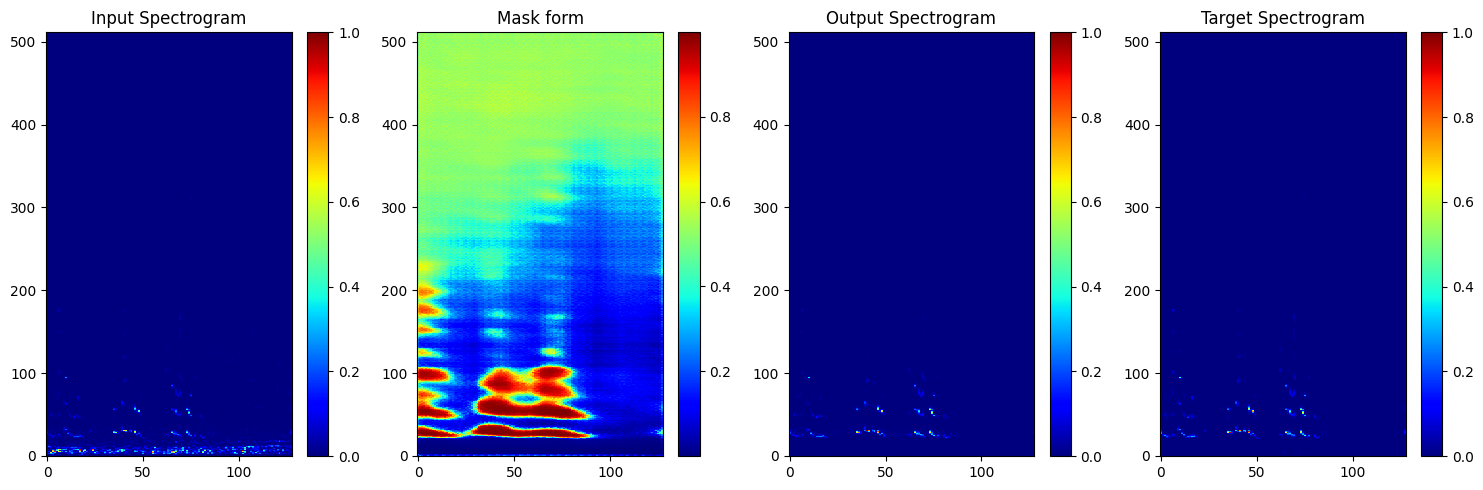

In [10]:
model = baseline_source_separation()
model.load_state_dict(torch.load('baseline_source_separation.pth',weights_only=True))
model.eval()  
sample = 'test/0002/mix_snr_-3.wav'
fe, data = scipy.io.wavfile.read(sample)
input_spectrogram = to_spectrogram(data, fe)
input_tensor = torch.tensor(input_spectrogram).unsqueeze(0).unsqueeze(0).float()

device = 'cpu'  
model.to(device)
input_tensor = input_tensor.to(device)
with torch.no_grad():  
    output = model(input_tensor)

mask = output.squeeze().cpu().numpy()
#maintenant, on peut multiplier le mask avec l'input

target_voice = 'test/0002/voice.wav'
fe,data = scipy.io.wavfile.read(target_voice)
target_spectrogram = to_spectrogram(data,fe)

output_spectrogram = mask*input_spectrogram
output_spectrogram = (output_spectrogram-np.min(output_spectrogram))/(np.max(output_spectrogram)-np.min(output_spectrogram))
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(input_spectrogram, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Input Spectrogram')
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(mask, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Mask form')
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(output_spectrogram, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Output Spectrogram')
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(target_spectrogram, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Target Spectrogram')
plt.colorbar()

plt.tight_layout()
plt.show()


Maintenant, on peut coder le modèle U-Net proposé par l'article.

In [11]:
class u_net_source_separation(nn.Module):
    def __init__(self):
        torch.nn.Module.__init__(self)
        #encode
        self.conv1 = nn.Conv2d(1,16,kernel_size=5,stride=2,padding=2)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,kernel_size=5,stride=2,padding=2)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,kernel_size=5,stride=2,padding=2)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64,128,kernel_size=5,stride=2,padding=2)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128,256,kernel_size=5,stride=2,padding=2)
        self.batch_norm5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256,512,kernel_size=5,stride=2,padding=2)
        self.batch_norm6 = nn.BatchNorm2d(512)

        #decode
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm1_d = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout2d(0.5)
        self.deconv2 = nn.ConvTranspose2d(512, 128, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm2_d = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(0.5)
        self.deconv3 = nn.ConvTranspose2d(256, 64, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm3_d = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout2d(0.5)
        self.deconv4 = nn.ConvTranspose2d(128, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm4_d = nn.BatchNorm2d(32)
        self.deconv5 = nn.ConvTranspose2d(64, 16, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm5_d = nn.BatchNorm2d(16)
        self.deconv6 = nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.batch_norm6_d = nn.BatchNorm2d(1)

        #activation
        self.Lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #encode
        x = self.Lrelu(self.batch_norm1(self.conv1(x)))
        x1 = x.clone()
        x = self.Lrelu(self.batch_norm2(self.conv2(x)))
        x2 = x.clone()
        x = self.Lrelu(self.batch_norm3(self.conv3(x)))
        x3 = x.clone()
        x = self.Lrelu(self.batch_norm4(self.conv4(x)))
        x4 = x.clone()
        x = self.Lrelu(self.batch_norm5(self.conv5(x)))
        x5 = x.clone()
        x = self.Lrelu(self.batch_norm6(self.conv6(x)))
        #decode
        x = self.relu(self.batch_norm1_d(self.deconv1(x)))
        x = self.dropout1(x)
        x = torch.cat([x, x5], dim=1)
        x = self.relu(self.batch_norm2_d(self.deconv2(x)))
        x = self.dropout2(x)
        x = torch.cat([x, x4], dim=1)
        x = self.relu(self.batch_norm3_d(self.deconv3(x)))
        x = self.dropout3(x)
        x = torch.cat([x, x3], dim=1)
        x = self.relu(self.batch_norm4_d(self.deconv4(x)))
        x = torch.cat([x, x2], dim=1)
        x = self.relu(self.batch_norm5_d(self.deconv5(x)))
        x = torch.cat([x, x1], dim=1)
        x = self.sigmoid(self.batch_norm6_d(self.deconv6(x)))
        return x
    

model = u_net_source_separation()
dummy_input = torch.randn(5,1,512,128)
output = model(dummy_input)
print(output.shape)

torch.Size([5, 1, 512, 128])


On va essayer d'apprendre le masque qui permet d'isoler la voix. La fonction de perte utilisée est la norme $L_1$ de la matrice du spectrogramme complet multipliée avec le masque comparé à la matrice du spectrogramme de la voix isolée.

On peut réaliser l'entraînement.

In [14]:
# Paramètres de l'entraînement
num_epochs = 10
batch_size = 25
learning_rate = 0.0001

train = 'train/'  
dataset_train = MyDataset(dir=train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

test = 'test/'
dataset_test = MyDataset(dir=test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

model = u_net_source_separation()
criterion = Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = 'cpu'
model.to(device)

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0

    for batch_idx, (spectrograms, mix_path, noise_path, voice_path) in enumerate(dataloader_train):
        spectrograms = spectrograms.to(device).unsqueeze(1)  

        target_spectrograms = []

        for vp in voice_path:
            sample_rate, waveform_voice = scipy.io.wavfile.read(vp)
            target_spectrogram = to_spectrogram(waveform_voice, fe=sample_rate)
            target_spectrograms.append(target_spectrogram)
        
        target = torch.tensor(target_spectrograms).to(device).unsqueeze(1)

        optimizer.zero_grad()

        #forward pass
        output = model(spectrograms)

        loss = criterion(output, spectrograms, target)

        #backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        #if batch_idx % 50 == 49:
        #    print(f"Epoch [{epoch + 1}/{num_epochs}], Batch {batch_idx + 1}, Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss moyenne: {running_loss / len(dataloader):.4f}")
    
    model.eval() 
    valid_loss = 0.0

    with torch.no_grad():  
        for batch_idx, (spectrograms, mix_path, noise_path, voice_path) in enumerate(dataloader_test):
            spectrograms = spectrograms.to(device).unsqueeze(1)

            target_spectrograms = []

            for vp in voice_path:
                sample_rate, waveform_voice = scipy.io.wavfile.read(vp)
                target_spectrogram = to_spectrogram(waveform_voice, fe=sample_rate)
                target_spectrograms.append(target_spectrogram)

            target = torch.tensor(target_spectrograms).to(device).unsqueeze(1)

            # Forward pass
            output = model(spectrograms)

            # Calcul de la perte
            loss = criterion(output, spectrograms, target)
            valid_loss += loss.item()

        # Moyenne de la perte sur le dataset de test
        valid_loss /= len(dataloader_test)

    print(f"Validation Loss après l'époque {epoch + 1}: {valid_loss:.4f}")


# Sauvegarder le modèle
torch.save(model.state_dict(), "u_net_source_separation.pth")


Epoch [1/10] - Loss moyenne: 81.0179
Validation Loss après l'époque 1: 323.0479
Epoch [2/10] - Loss moyenne: 50.4192
Validation Loss après l'époque 2: 286.2556
Epoch [3/10] - Loss moyenne: 46.0331
Validation Loss après l'époque 3: 272.5923
Epoch [4/10] - Loss moyenne: 43.7267
Validation Loss après l'époque 4: 257.1304
Epoch [5/10] - Loss moyenne: 42.1376
Validation Loss après l'époque 5: 256.1075
Epoch [6/10] - Loss moyenne: 40.9338
Validation Loss après l'époque 6: 244.2810
Epoch [7/10] - Loss moyenne: 39.9590
Validation Loss après l'époque 7: 240.4075
Epoch [8/10] - Loss moyenne: 39.1397
Validation Loss après l'époque 8: 243.1499
Epoch [9/10] - Loss moyenne: 38.5078
Validation Loss après l'époque 9: 231.4190
Epoch [10/10] - Loss moyenne: 37.9307
Validation Loss après l'époque 10: 234.8081


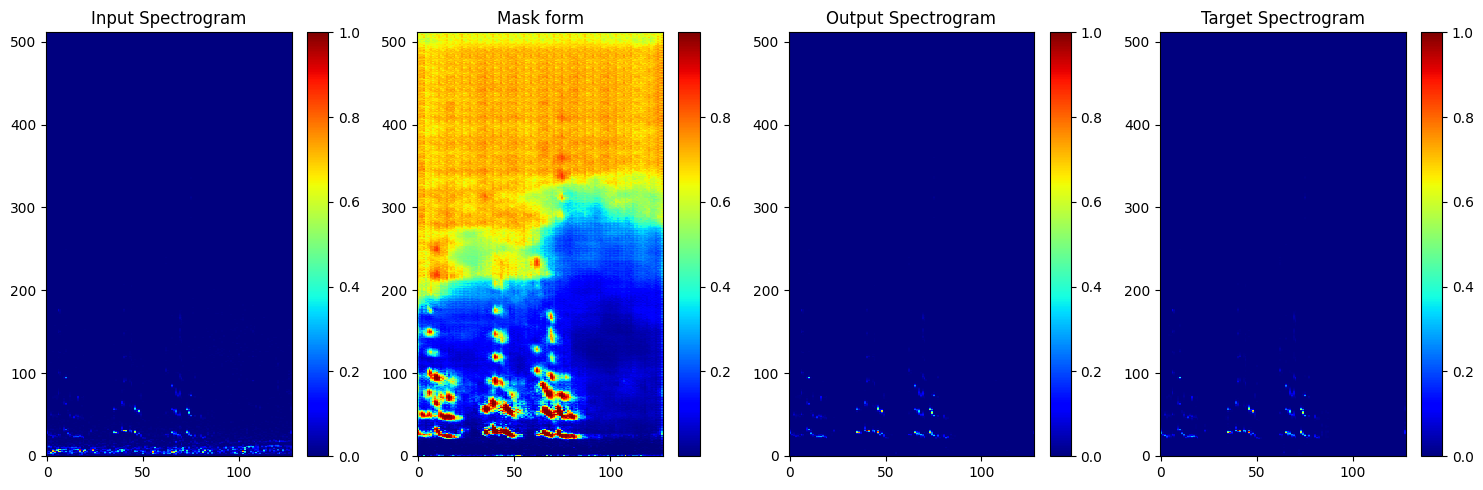

In [13]:
model = u_net_source_separation()
model.load_state_dict(torch.load('u_net_source_separation.pth',weights_only=True))
model.eval()  
sample = 'test/0002/mix_snr_-3.wav'
fe, data = scipy.io.wavfile.read(sample)
input_spectrogram = to_spectrogram(data, fe)
input_tensor = torch.tensor(input_spectrogram).unsqueeze(0).unsqueeze(0).float()

device = 'cpu'  
model.to(device)
input_tensor = input_tensor.to(device)
with torch.no_grad():  
    output = model(input_tensor)

mask = output.squeeze().cpu().numpy()
#maintenant, on peut multiplier le mask avec l'input

output_spectrogram = mask*input_spectrogram
output_spectrogram = (output_spectrogram-np.min(output_spectrogram))/(np.max(output_spectrogram)-np.min(output_spectrogram))
target_voice = 'test/0002/voice.wav'
fe,data = scipy.io.wavfile.read(target_voice)
target_spectrogram = to_spectrogram(data,fe)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(input_spectrogram, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Input Spectrogram')
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(mask, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Mask form')
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(output_spectrogram, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Output Spectrogram')
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(target_spectrogram, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Target Spectrogram')
plt.colorbar()

plt.tight_layout()
plt.show()


Quelques remarques, dans l'input, on se rend compte que les harmoniques apparaissent effectivement. Le masque a bien compris cette apparition naturelle des harmoniques et a bien saisi la structure naturelle du spectrogramme de plus, on voit aussi que le masque a compris les pauses dans la parole. Le masque ci-dessus semble plus précis sur les zones d'intérêt que le premier masque baseline. Le spectrogramme de sortie a bien filtré les artefacts présents dans l'entrée et il est comparable avec le spectrogramme que l'on souhaitait obtenir.

On aimerait aussi reconstruire le signal, pour écouter le signal filtré. Comme on a travaillé sur le spectrogramme normalisé, il faut travailler un peu plus pour reconstruire le signal filtré.

In [12]:
def to_spectrogram_reconstruction(data,fe):
    nb = 1022
    nperseg = nb  
    noverlap = nb // 2 
    data = data[:64897]
    f, tfct, Zxx = stft(data, fs=fe, nperseg=nperseg, nfft=nb, noverlap=noverlap, window='hamming')
    Zxx_phase = np.angle(Zxx)
    Zxx_magnitude = np.abs(Zxx)**2
    magnitude_max = np.max(Zxx_magnitude)
    magnitude_min = np.min(Zxx_magnitude)
    Zxx_normalized = (Zxx_magnitude - np.min(Zxx_magnitude)) / (np.max(Zxx_magnitude)-np.min(Zxx_magnitude))
    return Zxx_normalized,Zxx_phase,magnitude_max,magnitude_min

def masked_spectrogram_to_complex_spectrogram(Zxx_post_mask,Zxx_phase,magnitude_max,magnitude_min,fe):
    Zxx_magnitude = (np.sqrt(Zxx_post_mask)*(magnitude_max-magnitude_min) + magnitude_min)
    Zxx_complexe = Zxx_magnitude*np.exp(1j * Zxx_phase)
    _,signal = istft(Zxx_complexe,fe,window='hamming',nperseg = 1022,noverlap = 511,nfft=1022)
    return signal

model = u_net_source_separation()
model.load_state_dict(torch.load('u_net_source_separation.pth',weights_only=True))
model.eval()  
sample = 'test/0002/mix_snr_-3.wav'
fe, data = scipy.io.wavfile.read(sample)
input_spectrogram,phase,max,min = to_spectrogram_reconstruction(data, fe)

input_tensor = torch.tensor(input_spectrogram).unsqueeze(0).unsqueeze(0).float()

device = 'cpu'  
model.to(device)
input_tensor = input_tensor.to(device)
with torch.no_grad():  
    output = model(input_tensor)

mask = output.squeeze().cpu().numpy()
spectrogram_output = mask*input_spectrogram
spectrogram_output = (spectrogram_output-np.min(spectrogram_output))/(np.max(spectrogram_output)-np.min(spectrogram_output))

signal = masked_spectrogram_to_complex_spectrogram(spectrogram_output,phase,max,min,fe)
display(ipd.Audio(signal, rate=fe))

In [13]:
fe1, data1 = scipy.io.wavfile.read('test/0002/mix_snr_-3.wav')
print("Signal brut : mix_snr_-3.wav")
display(ipd.Audio(data1, rate=fe1))

Signal brut : mix_snr_-3.wav


Les spectrogrammes étant maintenant similaires, appliquons la transformée inverse aux deux spectrogrammes : target et reconstruits pour pouvoir comparer les formes d'onde.

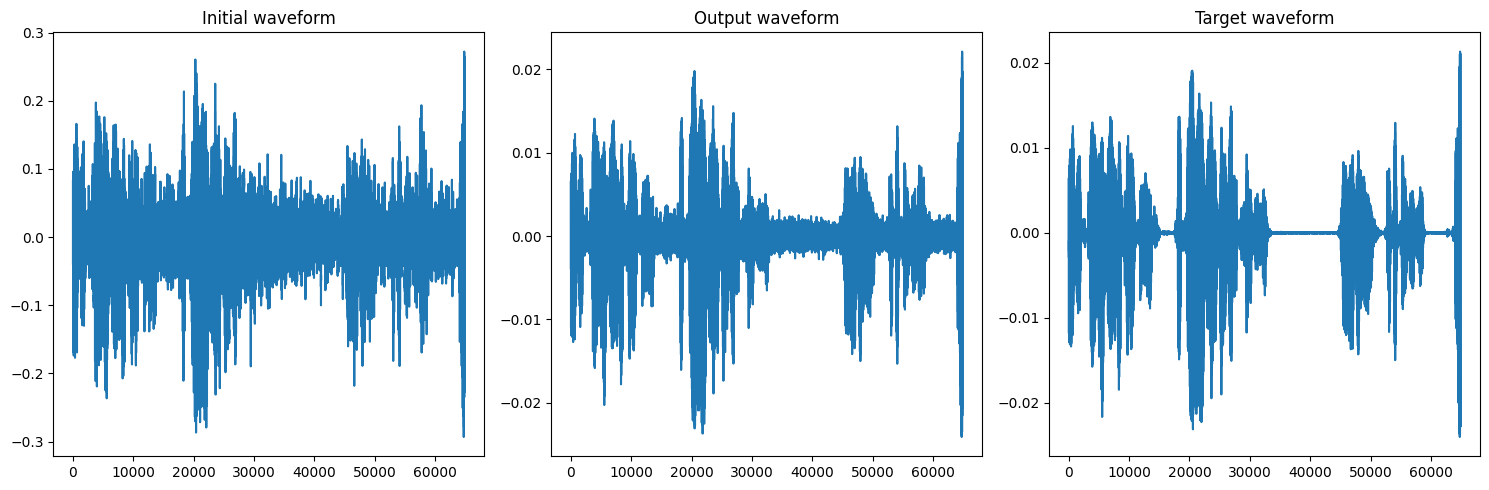

In [14]:
fe, data_target = scipy.io.wavfile.read('test/0001/voice.wav')

model = u_net_source_separation()
model.load_state_dict(torch.load('u_net_source_separation.pth',weights_only=True))
model.eval()  
sample = 'test/0001/mix_snr_2.wav'
sample_target = 'test/0001/voice.wav'

fe, data = scipy.io.wavfile.read(sample)
fe1,target_data = scipy.io.wavfile.read(sample_target)

input_spectrogram,phase,max,min = to_spectrogram_reconstruction(data, fe)
target_spectrogram = to_spectrogram(data_target,fe1)
input_tensor = torch.tensor(input_spectrogram).unsqueeze(0).unsqueeze(0).float()

device = 'cpu'  
model.to(device)
input_tensor = input_tensor.to(device)
with torch.no_grad():  
    output = model(input_tensor)

mask = output.squeeze().cpu().numpy()
spectrogram_output = mask*input_spectrogram
spectrogram_output = (spectrogram_output-np.min(spectrogram_output))/(np.max(spectrogram_output)-np.min(spectrogram_output))

signal = masked_spectrogram_to_complex_spectrogram(spectrogram_output,phase,max,min,fe)
signal_target = masked_spectrogram_to_complex_spectrogram(target_spectrogram,phase,max,min,fe)

plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.plot(data[:64897])
plt.title('Initial waveform')

plt.subplot(1, 3, 2)
plt.plot(signal)
plt.title('Output waveform')

plt.subplot(1, 3, 3)
plt.plot(signal_target[:64897])
plt.title('Target waveform')

plt.tight_layout()
plt.show()

On a réussi à enlever le bruit mais on a quand même une perte de clarté au niveau de la voix. Il y a aussi un problème d'échelle pour le spectrogramme d'output, on va le renormaliser pour être plus proche de la target.

Au delà de l'estimation qualitative de la qualité du signal, on propose d'étudier le signal to distortion ratio (SDR) :
$$
SDR(S_r,S_i)=10\log_{10}\left(\frac{\lVert S_i\rVert^2}{\lVert S_r-S_i\rVert^2}\right),
$$
où $S_r,S_i$ sont respectivement le signal reconstruit et le signal isolé.

In [15]:
def compute_sdr(s_1, s_2):
    #computes SDR
    reference_energy = np.sum(s_2 ** 2)
    error = s_1 - s_2
    error_energy = np.sum(error ** 2)
    sdr = 10 * np.log10(reference_energy/error_energy) 
    return sdr

def mse(signal_reconstruit,signal_isole):
    #computes mean squared error
    error = signal_reconstruit - signal_isole
    error_energy = np.sum(error ** 2)
    return error_energy

In [67]:
sdr_mean_baseline = 0
sdr_mean_unet = 0
mse_unet = 0
mse_baseline = 0
baseline = baseline_source_separation()
baseline.load_state_dict(torch.load('baseline_source_separation.pth',weights_only=True))

unet = u_net_source_separation()
unet.load_state_dict(torch.load('u_net_source_separation.pth',weights_only=True))

for i in range(2000):
    if i <10:
        fe1, data1 = scipy.io.wavfile.read(f'test/000{i}/voice.wav')
        file_path = glob(f'test/000{i}/mix_snr*')[0]  
        fe2, data2 = scipy.io.wavfile.read(file_path)
    elif i<100:
        fe1, data1 = scipy.io.wavfile.read(f'test/00{i}/voice.wav')
        file_path = glob(f'test/00{i}/mix_snr*')[0]  
        fe2, data2 = scipy.io.wavfile.read(file_path)
    elif i<1000:
        fe1, data1 = scipy.io.wavfile.read(f'test/0{i}/voice.wav')
        file_path = glob(f'test/0{i}/mix_snr*')[0]  
        fe2, data2 = scipy.io.wavfile.read(file_path)
    else:
        fe1, data1 = scipy.io.wavfile.read(f'test/{i}/voice.wav')
        file_path = glob(f'test/{i}/mix_snr*')[0]  
        fe2, data2 = scipy.io.wavfile.read(file_path)

    data1 = data1[:64897]
    data2 = data2[:64897]
    target_spectrogram = to_spectrogram(data1,fe1)

    input_spectrogram,phase,max,min = to_spectrogram_reconstruction(data2, fe2)
    input_tensor = torch.tensor(input_spectrogram).unsqueeze(0).unsqueeze(0).float()

    device = 'cpu'  

    baseline.to(device)
    input_tensor = input_tensor.to(device)
    with torch.no_grad():  
        output = baseline(input_tensor)

    mask = output.squeeze().cpu().numpy()
    spectrogram_output = mask*input_spectrogram
    spectrogram_output = (spectrogram_output-np.min(spectrogram_output))/(np.max(spectrogram_output)-np.min(spectrogram_output))
    signal_baseline = masked_spectrogram_to_complex_spectrogram(spectrogram_output,phase,max,min,fe)
    signal_target = masked_spectrogram_to_complex_spectrogram(target_spectrogram,phase,max,min,fe)

    mse_baseline += mse(signal_baseline,signal_target)
    sdr_mean_baseline += compute_sdr(signal_baseline,signal_target) 

    unet.to(device)
    input_tensor = input_tensor.to(device)
    with torch.no_grad():  
        output = unet(input_tensor)

    mask = output.squeeze().cpu().numpy()
    spectrogram_output = mask*input_spectrogram
    spectrogram_output = (spectrogram_output-np.min(spectrogram_output))/(np.max(spectrogram_output)-np.min(spectrogram_output))

    signal_unet = masked_spectrogram_to_complex_spectrogram(spectrogram_output,phase,max,min,fe)
    mse_unet += mse(signal_unet,signal_target)
    sdr_mean_unet += compute_sdr(signal_unet,signal_target) 

print(f'Le SDR moyen du U-Net sans skip connections vaut:{sdr_mean_baseline/2000}, le MSE vaut:{mse_baseline/2000}')
print(f'Le SDR moyen de U-Net vaut:{sdr_mean_unet/2000}, le MSE vaut: {mse_unet/2000}')


Le SDR moyen du U-Net sans skip connections vaut:10.850132942199707, le MSE vaut:0.047774285078048706
Le SDR moyen de U-Net vaut:12.392230987548828, le MSE vaut: 0.034852035343647


La baseline semble être déjà très bonne et semble capturer les données précisément (au même niveau que le U-Net voire potentiellement mieux selon la métrique). Peut-être qu'on n'a pas assez de données ou de variabilité (toujours la même femme qui parle, peut-être pas assez de variabilité dans les bruits...). On a aussi accès aux valeurs du NSR dans les documents. Il pourrait être intéressant de voir la répartition des NSDR selon les différentes valeurs de NSR.

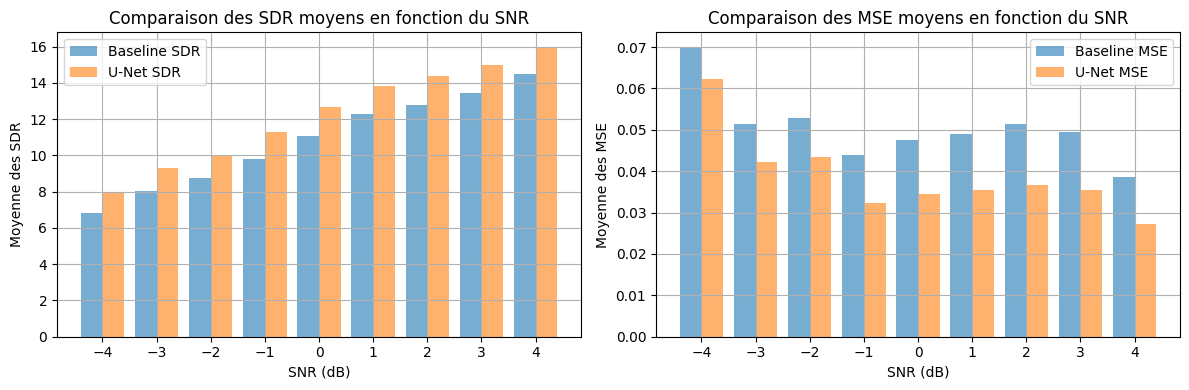

In [68]:
snr_values = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
snr_sdr_values_baseline = {snr: [] for snr in snr_values}
snr_sdr_values_unet = {snr: [] for snr in snr_values}
snr_mse_values_baseline = {snr: [] for snr in snr_values}
snr_mse_values_unet = {snr: [] for snr in snr_values}

# Parcourir les fichiers
for i in range(2000):
    if i < 10:
        folder_path = f'test/000{i}'
    elif i < 100:
        folder_path = f'test/00{i}'
    elif i < 1000:
        folder_path = f'test/0{i}'
    else:
        folder_path = f'test/{i}'
    
    # Charger les fichiers voix et mélange
    fe1, data1 = scipy.io.wavfile.read(f'{folder_path}/voice.wav')
    file_path = glob(f'{folder_path}/mix_snr*')[0]
    fe2, data2 = scipy.io.wavfile.read(file_path)
    
    # Extraire le SNR à partir du nom du fichier
    snr_match = re.search(r'mix_snr_(-?\d+)', file_path)
    if snr_match:
        snr = int(snr_match.group(1))
    
    data1 = data1[:64897]
    data2 = data2[:64897]
    
    target_spectrogram=to_spectrogram(data1,fe)
    input_spectrogram, phase, max_val, min_val = to_spectrogram_reconstruction(data2, fe2)
    input_tensor = torch.tensor(input_spectrogram).unsqueeze(0).unsqueeze(0).float()
    
    device = 'cpu'
    input_tensor = input_tensor.to(device)

    baseline.to(device)
    with torch.no_grad():
        output_baseline = baseline(input_tensor)

    mask_baseline = output_baseline.squeeze().cpu().numpy()
    spectrogram_baseline = mask_baseline * input_spectrogram
    signal_baseline = masked_spectrogram_to_complex_spectrogram(
        spectrogram_baseline, phase, max_val, min_val, fe2
    )
    signal_target = masked_spectrogram_to_complex_spectrogram(
        target_spectrogram, phase, max_val, min_val, fe2
    )
    sdr_baseline = compute_sdr(signal_baseline,signal_target)
    snr_sdr_values_baseline[snr].append(sdr_baseline)
    snr_mse_values_baseline[snr].append(mse(signal_baseline,signal_target))
    unet.to(device)
    with torch.no_grad():
        output_unet = unet(input_tensor)

    mask_unet = output_unet.squeeze().cpu().numpy()
    spectrogram_unet = mask_unet * input_spectrogram
    signal_unet = masked_spectrogram_to_complex_spectrogram(
        spectrogram_unet, phase, max_val, min_val, fe2
    )
    sdr_unet = compute_sdr(signal_unet,signal_target)
    snr_sdr_values_unet[snr].append(sdr_unet)
    snr_mse_values_unet[snr].append(mse(signal_unet,signal_target))

baseline_means = [np.mean(snr_sdr_values_baseline[snr]) for snr in snr_values]
unet_means = [np.mean(snr_sdr_values_unet[snr]) for snr in snr_values]

mse_baseline=[np.mean(snr_mse_values_baseline[snr]) for snr in snr_values]
mse_unet = [np.mean(snr_mse_values_unet[snr]) for snr in snr_values]

snr_values = np.array(snr_values)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(snr_values - 0.2, baseline_means, width=0.4, label='Baseline SDR', alpha=0.6, align='center')
axes[0].bar(snr_values + 0.2, unet_means, width=0.4, label='U-Net SDR', alpha=0.6, align='center')
axes[0].set_xlabel('SNR (dB)')
axes[0].set_ylabel('Moyenne des SDR')
axes[0].set_title('Comparaison des SDR moyens en fonction du SNR')
axes[0].set_xticks(snr_values)
axes[0].legend()
axes[0].grid()

axes[1].bar(snr_values - 0.2, mse_baseline, width=0.4, label='Baseline MSE', alpha=0.6, align='center')
axes[1].bar(snr_values + 0.2, mse_unet, width=0.4, label='U-Net MSE', alpha=0.6, align='center')
axes[1].set_xlabel('SNR (dB)')
axes[1].set_ylabel('Moyenne des MSE')
axes[1].set_title('Comparaison des MSE moyens en fonction du SNR')
axes[1].set_xticks(snr_values)
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


Une métrique utilisée par l'article est le NSDR défini par :
$$
NSDR(S_r,S_i,S_m)=SDR(S_r,S_i)-SDR(S_m,S_i).
$$
$S_r,S_i,S_m$ sont respectivement le signal reconstruit, le signal isolé et le signal mixé (bruit et voix). L'objectif de cette métrique est de capter en plus la difficulté de reconstruction du signal (comprise par le deuxième SDR).

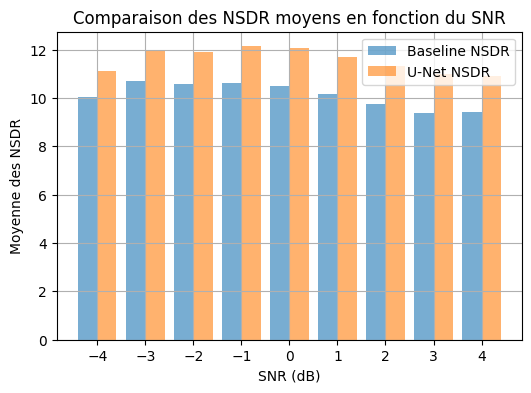

Le NSDR moyen de la baseline est 10.163041114807129
Le NSDR moyen du U-net est 11.620057106018066


In [71]:
snr_values = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
snr_nsdr_values_baseline = {snr: [] for snr in snr_values}
snr_nsdr_values_unet = {snr: [] for snr in snr_values}
mean_nsdr_baseline =0
mean_nsdr_unet=0

# Parcourir les fichiers
for i in range(2000):
    if i < 10:
        folder_path = f'test/000{i}'
    elif i < 100:
        folder_path = f'test/00{i}'
    elif i < 1000:
        folder_path = f'test/0{i}'
    else:
        folder_path = f'test/{i}'
    
    # Charger les fichiers voix et mélange
    fe1, data1 = scipy.io.wavfile.read(f'{folder_path}/voice.wav')
    file_path = glob(f'{folder_path}/mix_snr*')[0]
    fe2, data2 = scipy.io.wavfile.read(file_path)
    
    # Extraire le SNR à partir du nom du fichier
    snr_match = re.search(r'mix_snr_(-?\d+)', file_path)
    if snr_match:
        snr = int(snr_match.group(1))
    
    data1 = data1[:64897]
    data2 = data2[:64897]
    
    target_spectrogram=to_spectrogram(data1,fe)
    input_spectrogram, phase, max_val, min_val = to_spectrogram_reconstruction(data2, fe2)
    input_tensor = torch.tensor(input_spectrogram).unsqueeze(0).unsqueeze(0).float()
    
    device = 'cpu'
    input_tensor = input_tensor.to(device)

    baseline.to(device)
    with torch.no_grad():
        output_baseline = baseline(input_tensor)

    mask_baseline = output_baseline.squeeze().cpu().numpy()
    spectrogram_baseline = mask_baseline * input_spectrogram
    signal_baseline = masked_spectrogram_to_complex_spectrogram(
        spectrogram_baseline, phase, max_val, min_val, fe2
    )
    signal_target = masked_spectrogram_to_complex_spectrogram(
        target_spectrogram, phase, max_val, min_val, fe2
    )
    signal_mix = masked_spectrogram_to_complex_spectrogram(
        input_spectrogram, phase, max_val, min_val, fe2
    )


    nsdr_baseline = compute_sdr(signal_baseline,signal_target)-compute_sdr(signal_mix,signal_target)
    snr_nsdr_values_baseline[snr].append(nsdr_baseline)
    mean_nsdr_baseline += nsdr_baseline
    unet.to(device)
    with torch.no_grad():
        output_unet = unet(input_tensor)

    mask_unet = output_unet.squeeze().cpu().numpy()
    spectrogram_unet = mask_unet * input_spectrogram
    signal_unet = masked_spectrogram_to_complex_spectrogram(
        spectrogram_unet, phase, max_val, min_val, fe2
    )
    nsdr_unet = compute_sdr(signal_unet,signal_target)-compute_sdr(signal_mix,signal_target)
    snr_nsdr_values_unet[snr].append(nsdr_unet)
    mean_nsdr_unet +=nsdr_unet

baseline_means_nsdr = [np.mean(snr_nsdr_values_baseline[snr]) for snr in snr_values]
unet_means_nsdr = [np.mean(snr_nsdr_values_unet[snr]) for snr in snr_values]

plt.figure(figsize=(6, 4))
plt.bar(np.array(snr_values) - 0.2, baseline_means_nsdr, width=0.4, label='Baseline NSDR', alpha=0.6, align='center')
plt.bar(np.array(snr_values) + 0.2, unet_means_nsdr, width=0.4, label='U-Net NSDR', alpha=0.6, align='center')

plt.xlabel('SNR (dB)')
plt.ylabel('Moyenne des NSDR')
plt.title('Comparaison des NSDR moyens en fonction du SNR')
plt.xticks(snr_values)
plt.legend()
plt.grid()
plt.show()

print(f'Le NSDR moyen de la baseline est {mean_nsdr_baseline/2000}')
print(f'Le NSDR moyen du U-net est {mean_nsdr_unet/2000}')

Dans l'article "Singing voice separation with Deepu U-NET convolutional network" de Jansson et al. qui est à l'origine de ce travail, le NSDR moyen de la voix que l'on obtient sur la séparation voix-instrumentale est environ 11dB pour le modèle U-Net et 8.5dB pour la baseline, c'est plutôt cohérent avec ce que l'on obtient même la baseline semble mieux performer ici, les données d'entraînement, de test et la tâche en elle-même n'étant pas rigoureusement les mêmes, cette variabilité peut donc être expliquée. Cette métrique permet de voir que la capacité de séparation est en fait plutôt constante en fonction du SNR malgré ce qu'on aurait pu penser avec le SDR.

Je voulais ensuite voir l'impact de la validation loss (norme L1) sur le NSDR moyen. On a une corrélation linéaire, ce qui est assez impressionnant.

In [18]:
# Paramètres de l'entraînement
num_epochs = 10
batch_size = 25
learning_rate = 0.0001
loss_valid = []
nsdr_valid=[]
train = 'train/'  
dataset_train = MyDataset(dir=train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

test = 'test/'
dataset_test = MyDataset(dir=test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

model = baseline_source_separation()
criterion = Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = 'cpu'
model.to(device)

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0

    for batch_idx, (spectrograms, mix_path, noise_path, voice_path) in enumerate(dataloader_train):
        spectrograms = spectrograms.to(device).unsqueeze(1)  

        target_spectrograms = []

        for vp in voice_path:
            sample_rate, waveform_voice = scipy.io.wavfile.read(vp)
            target_spectrogram = to_spectrogram(waveform_voice, fe=sample_rate)
            target_spectrograms.append(target_spectrogram)
        
        target = torch.tensor(target_spectrograms).to(device).unsqueeze(1)

        optimizer.zero_grad()

        #forward pass
        output = model(spectrograms)

        loss = criterion(output, spectrograms, target)

        #backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        #if batch_idx % 50 == 49:
        #    print(f"Epoch [{epoch + 1}/{num_epochs}], Batch {batch_idx + 1}, Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss moyenne: {running_loss / len(dataloader):.4f}")
    model.eval() 
    valid_loss = 0.0

    with torch.no_grad():  
        for batch_idx, (spectrograms, mix_path, noise_path, voice_path) in enumerate(dataloader_test):
            spectrograms = spectrograms.to(device).unsqueeze(1)

            target_spectrograms = []

            for vp in voice_path:
                sample_rate, waveform_voice = scipy.io.wavfile.read(vp)
                target_spectrogram = to_spectrogram(waveform_voice, fe=sample_rate)
                target_spectrograms.append(target_spectrogram)

            target = torch.tensor(target_spectrograms).to(device).unsqueeze(1)

            # Forward pass
            output = model(spectrograms)

            # Calcul de la perte
            loss = criterion(output, spectrograms, target)
            valid_loss += loss.item()

        # Moyenne de la perte sur le dataset de test
        valid_loss /= len(dataloader_test)

    print(f"Validation Loss après l'époque {epoch + 1}: {valid_loss:.4f}")
    loss_valid.append(valid_loss)
    nsdr_step = 0

    for i in range(2000):
        if i < 10:
            folder_path = f'test/000{i}'
        elif i < 100:
            folder_path = f'test/00{i}'
        elif i < 1000:
            folder_path = f'test/0{i}'
        else:
            folder_path = f'test/{i}'
        
        # Charger les fichiers voix et mélange
        fe1, data1 = scipy.io.wavfile.read(f'{folder_path}/voice.wav')
        file_path = glob(f'{folder_path}/mix_snr*')[0]
        fe2, data2 = scipy.io.wavfile.read(file_path)
                
        data1 = data1[:64897]
        data2 = data2[:64897]
        
        target_spectrogram=to_spectrogram(data1,fe)
        input_spectrogram, phase, max_val, min_val = to_spectrogram_reconstruction(data2, fe2)
        input_tensor = torch.tensor(input_spectrogram).unsqueeze(0).unsqueeze(0).float()
        
        input_tensor = input_tensor.to(device)

        with torch.no_grad():
            output_baseline = model(input_tensor)

        mask_baseline = output_baseline.squeeze().cpu().numpy()
        spectrogram_baseline = mask_baseline * input_spectrogram
        signal_baseline = masked_spectrogram_to_complex_spectrogram(
            spectrogram_baseline, phase, max_val, min_val, fe2
        )
        signal_target = masked_spectrogram_to_complex_spectrogram(
            target_spectrogram, phase, max_val, min_val, fe2
        )
        signal_mix = masked_spectrogram_to_complex_spectrogram(
            input_spectrogram, phase, max_val, min_val, fe2
        )

        nsdr_step += compute_sdr(signal_baseline,signal_target)-compute_sdr(signal_mix,signal_target)
    
    nsdr_valid.append(nsdr_step/2000)

print(nsdr_valid)
print(loss_valid)

Epoch [1/10] - Loss moyenne: 76.7788
Validation Loss après l'époque 1: 358.7487
Epoch [2/10] - Loss moyenne: 57.7331
Validation Loss après l'époque 2: 352.5811
Epoch [3/10] - Loss moyenne: 53.5018
Validation Loss après l'époque 3: 305.9390
Epoch [4/10] - Loss moyenne: 50.9109
Validation Loss après l'époque 4: 305.4370
Epoch [5/10] - Loss moyenne: 49.1245
Validation Loss après l'époque 5: 293.2675
Epoch [6/10] - Loss moyenne: 47.7324
Validation Loss après l'époque 6: 287.3571
Epoch [7/10] - Loss moyenne: 46.6414
Validation Loss après l'époque 7: 282.3634
Epoch [8/10] - Loss moyenne: 45.8402
Validation Loss après l'époque 8: 279.1780
Epoch [9/10] - Loss moyenne: 45.1332
Validation Loss après l'époque 9: 283.8093
Epoch [10/10] - Loss moyenne: 44.4425
Validation Loss après l'époque 10: 273.9830
[np.float32(8.574548), np.float32(8.728154), np.float32(9.545148), np.float32(9.031875), np.float32(9.387516), np.float32(9.616752), np.float32(10.134682), np.float32(9.967273), np.float32(9.596926)

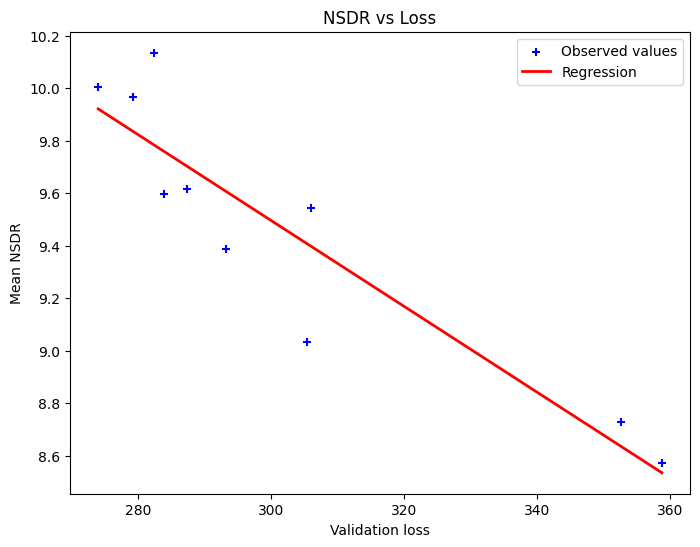

In [36]:
loss_valid = np.array(loss_valid)

X = loss_valid.reshape(-1, 1)  
y = nsdr_valid
model = LinearRegression()
model.fit(X, y)

x_range = np.linspace(loss_valid.min(), loss_valid.max(), 100).reshape(-1, 1)
y_pred = model.predict(x_range)

plt.figure(figsize=(8, 6))
plt.scatter(loss_valid, nsdr_valid, label="Observed values", color="blue",marker='+')
plt.plot(x_range, y_pred, label="Regression", color="red", linewidth=2)
plt.xlabel("Validation loss")
plt.ylabel("Mean NSDR")
plt.title("NSDR vs Loss")
plt.legend()
plt.show()


## Data augmentation on the spectrogram

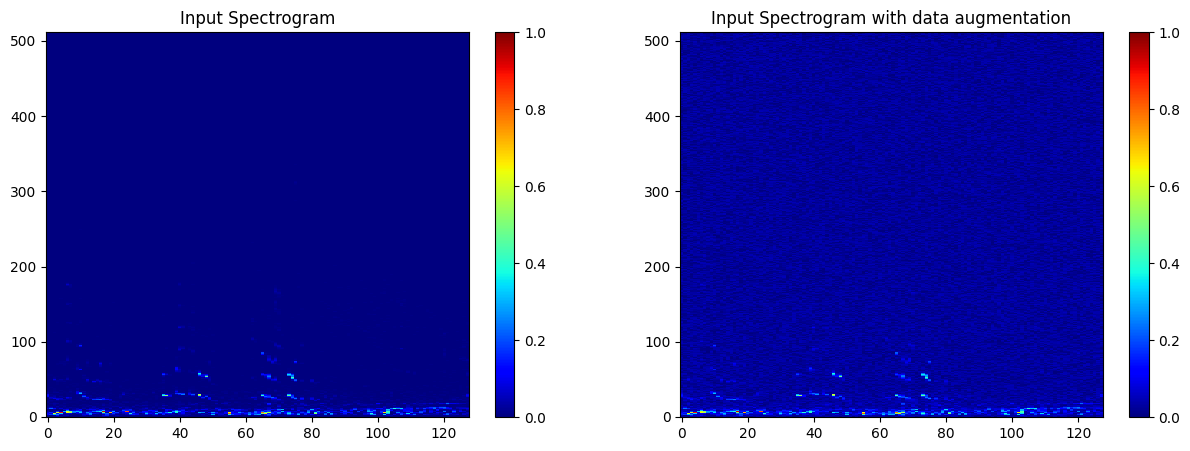

In [83]:
def add_noise_batch(batch, noise_level):
    noise = noise_level * torch.rand_like(batch)  #uniforme sur 0;1 qu'on multiplie par le noise_level positif aussi
    batch = batch+noise
    batch_min = batch.amin(dim=(1, 2), keepdim=True)  
    batch_max = batch.amax(dim=(1, 2), keepdim=True)  
    return (batch - batch_min) / (batch_max - batch_min)  

    
def augment_batch(batch, noise_level=0.05):
    batch = add_noise_batch(batch, noise_level)
    return batch

sample = 'test/0002/mix_snr_-3.wav'
fe, data = scipy.io.wavfile.read(sample)
input_spectrogram = to_spectrogram(data, fe)
input_tensor = torch.tensor(input_spectrogram).unsqueeze(0).unsqueeze(0).float()


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(input_spectrogram, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Input Spectrogram')
plt.colorbar()

input_tensor = input_tensor.squeeze(1)
input_tensor = augment_batch(input_tensor)
augment_tensor = np.array(input_tensor[0])

plt.subplot(1,2,2)
plt.imshow(np.array(augment_tensor), aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Input Spectrogram with data augmentation')
plt.colorbar()

Ce qui se passe maintenant c'est que le masque ne pourra pas être indifférent à ce qui se passe par exemple dans le haut du spectrogramme, il devra couper ces fréquences (en donnant la valeur 0 au masque dans le haut du spectrogramme notamment). Il devra apprendre aussi un peu plus précisément la voix.

In [84]:
# Paramètres de l'entraînement
num_epochs = 10
batch_size = 25
learning_rate = 0.0001

train = 'train/'  
dataset_train = MyDataset(dir=train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

test = 'test/'
dataset_test = MyDataset(dir=test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

model = u_net_source_separation()
criterion = Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = 'cpu'
model.to(device)

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0

    for batch_idx, (spectrograms, mix_path, noise_path, voice_path) in enumerate(dataloader_train):
        spectrograms = augment_batch(spectrograms)
        spectrograms = spectrograms.to(device).unsqueeze(1)  

        target_spectrograms = []

        for vp in voice_path:
            sample_rate, waveform_voice = scipy.io.wavfile.read(vp)
            target_spectrogram = to_spectrogram(waveform_voice, fe=sample_rate)
            target_spectrograms.append(target_spectrogram)
        
        target = torch.tensor(target_spectrograms).to(device).unsqueeze(1)

        optimizer.zero_grad()

        #forward pass
        output = model(spectrograms)

        loss = criterion(output, spectrograms, target)

        #backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        #if batch_idx % 50 == 49:
        #    print(f"Epoch [{epoch + 1}/{num_epochs}], Batch {batch_idx + 1}, Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss moyenne: {running_loss / len(dataloader):.4f}")
    
    model.eval() 
    valid_loss = 0.0

    with torch.no_grad():  
        for batch_idx, (spectrograms, mix_path, noise_path, voice_path) in enumerate(dataloader_test):
            spectrograms = spectrograms.to(device).unsqueeze(1)

            target_spectrograms = []

            for vp in voice_path:
                sample_rate, waveform_voice = scipy.io.wavfile.read(vp)
                target_spectrogram = to_spectrogram(waveform_voice, fe=sample_rate)
                target_spectrograms.append(target_spectrogram)

            target = torch.tensor(target_spectrograms).to(device).unsqueeze(1)

            # Forward pass
            output = model(spectrograms)

            # Calcul de la perte
            loss = criterion(output, spectrograms, target)
            valid_loss += loss.item()

        # Moyenne de la perte sur le dataset de test
        valid_loss /= len(dataloader_test)

    print(f"Validation Loss après l'époque {epoch + 1}: {valid_loss:.4f}")


# Sauvegarder le modèle
torch.save(model.state_dict(), "u_net_source_separation_augmentation.pth")


Epoch [1/10] - Loss moyenne: 2972.8376
Validation Loss après l'époque 1: 892.3420
Epoch [2/10] - Loss moyenne: 2602.9909
Validation Loss après l'époque 2: 829.8992
Epoch [3/10] - Loss moyenne: 2474.9138
Validation Loss après l'époque 3: 734.1771
Epoch [4/10] - Loss moyenne: 2394.6566
Validation Loss après l'époque 4: 677.4963
Epoch [5/10] - Loss moyenne: 2331.0414
Validation Loss après l'époque 5: 662.0532
Epoch [6/10] - Loss moyenne: 2277.4126
Validation Loss après l'époque 6: 641.7487
Epoch [7/10] - Loss moyenne: 2224.2558
Validation Loss après l'époque 7: 636.4639
Epoch [8/10] - Loss moyenne: 2175.2328
Validation Loss après l'époque 8: 632.2322
Epoch [9/10] - Loss moyenne: 2127.1168
Validation Loss après l'époque 9: 636.8009
Epoch [10/10] - Loss moyenne: 2079.1726
Validation Loss après l'époque 10: 664.8509


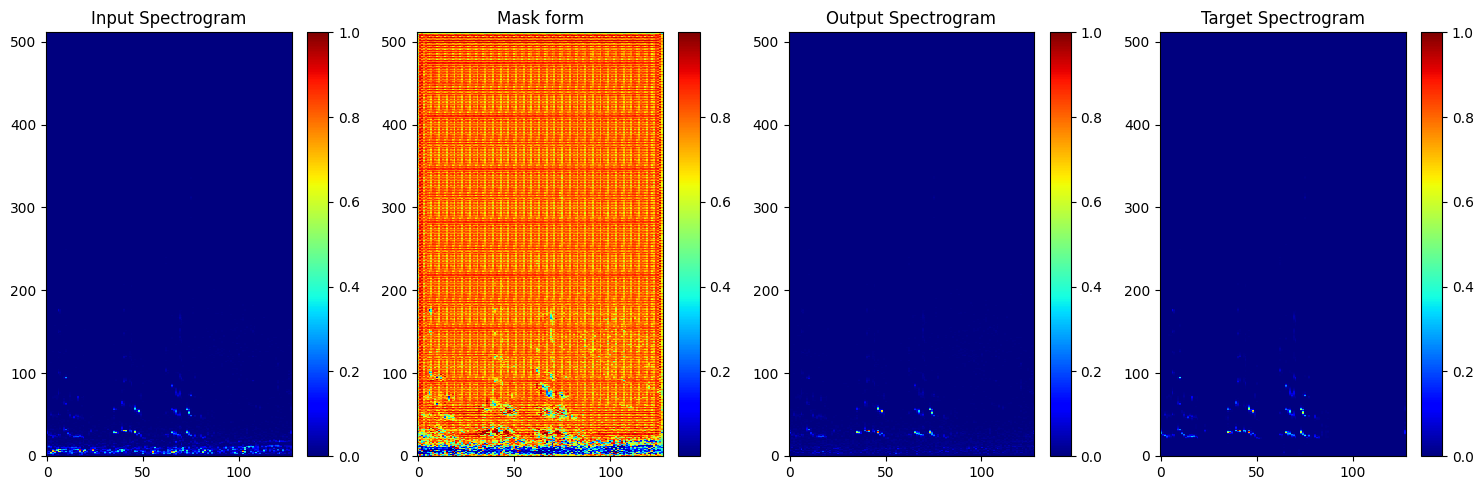

In [85]:
model = u_net_source_separation()
model.load_state_dict(torch.load('u_net_source_separation_augmentation.pth',weights_only=True))
model.eval()  
sample = 'test/0002/mix_snr_-3.wav'
fe, data = scipy.io.wavfile.read(sample)
input_spectrogram = to_spectrogram(data, fe)
input_tensor = torch.tensor(input_spectrogram).unsqueeze(0).unsqueeze(0).float()

device = 'cpu'  
model.to(device)
input_tensor = input_tensor.to(device)
with torch.no_grad():  
    output = model(input_tensor)

mask = output.squeeze().cpu().numpy()
#maintenant, on peut multiplier le mask avec l'input

output_spectrogram = mask*input_spectrogram
output_spectrogram = (output_spectrogram-np.min(output_spectrogram))/(np.max(output_spectrogram)-np.min(output_spectrogram))
target_voice = 'test/0002/voice.wav'
fe,data = scipy.io.wavfile.read(target_voice)
target_spectrogram = to_spectrogram(data,fe)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(input_spectrogram, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Input Spectrogram')
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(mask, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Mask form')
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(output_spectrogram, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Output Spectrogram')
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(target_spectrogram, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Target Spectrogram')
plt.colorbar()

plt.tight_layout()
plt.show()


On n'obtient pas ce qu'on pensait a priori.

Le MSE moyen avec la data augmentation est : 0.07837475836277008
Le SDR moyen avec la data augmentation est : 8.373017311096191
Le NSDR moyen avec la data augmentation est : 7.721208095550537


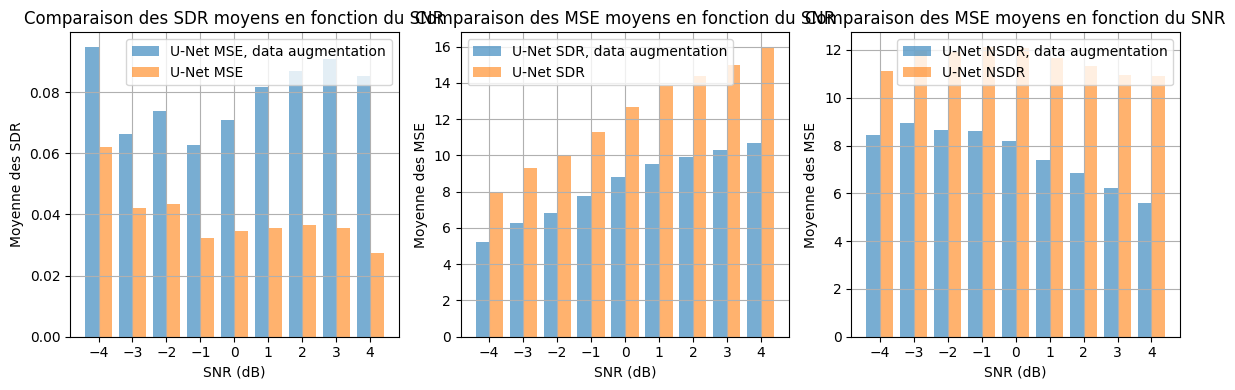

In [86]:
unet = u_net_source_separation()
unet.load_state_dict(torch.load('u_net_source_separation_augmentation.pth',weights_only=True))


snr_values = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
snr_sdr_values_unet = {snr: [] for snr in snr_values}
snr_nsdr_values_unet = {snr:[] for snr in snr_values}
snr_mse_values_unet = {snr: [] for snr in snr_values}

sdr_mean = 0
nsdr_mean = 0
mse_mean = 0

for i in range(2000):
    if i < 10:
        folder_path = f'test/000{i}'
    elif i < 100:
        folder_path = f'test/00{i}'
    elif i < 1000:
        folder_path = f'test/0{i}'
    else:
        folder_path = f'test/{i}'
    
    # audio file
    fe1, data1 = scipy.io.wavfile.read(f'{folder_path}/voice.wav')
    file_path = glob(f'{folder_path}/mix_snr*')[0]
    fe2, data2 = scipy.io.wavfile.read(file_path)
    
    # extraire le SNR
    snr_match = re.search(r'mix_snr_(-?\d+)', file_path)
    if snr_match:
        snr = int(snr_match.group(1))
    
    data1 = data1[:64897]
    data2 = data2[:64897]
    
    target_spectrogram=to_spectrogram(data1,fe)
    input_spectrogram, phase, max_val, min_val = to_spectrogram_reconstruction(data2, fe2)
    input_tensor = torch.tensor(input_spectrogram).unsqueeze(0).unsqueeze(0).float()
    
    device = 'cpu'
    input_tensor = input_tensor.to(device)

    signal_target = masked_spectrogram_to_complex_spectrogram(
        target_spectrogram, phase, max_val, min_val, fe2
    )
    signal_mix = masked_spectrogram_to_complex_spectrogram(
        input_spectrogram, phase, max_val, min_val, fe2
    )

    unet.to(device)
    with torch.no_grad():
        output_unet = unet(input_tensor)

    mask_unet = output_unet.squeeze().cpu().numpy()
    spectrogram_unet = mask_unet * input_spectrogram
    signal_unet = masked_spectrogram_to_complex_spectrogram(
        spectrogram_unet, phase, max_val, min_val, fe2
    )
    sdr_unet = compute_sdr(signal_unet,signal_target)
    snr_nsdr_values_unet[snr].append(sdr_unet - compute_sdr(signal_mix,signal_target))
    snr_sdr_values_unet[snr].append(sdr_unet)
    snr_mse_values_unet[snr].append(mse(signal_unet,signal_target))
    mse_mean+=mse(signal_unet,signal_target)
    nsdr_mean += sdr_unet - compute_sdr(signal_mix,signal_target)
    sdr_mean += sdr_unet

print(f'Le MSE moyen avec la data augmentation est : {mse_mean/2000}')
print(f'Le SDR moyen avec la data augmentation est : {sdr_mean/2000}')
print(f'Le NSDR moyen avec la data augmentation est : {nsdr_mean/2000}')

unet_means_data= [np.mean(snr_sdr_values_unet[snr]) for snr in snr_values]
mse_unet_data= [np.mean(snr_mse_values_unet[snr]) for snr in snr_values]
unet_nsdr_data = [np.mean(snr_nsdr_values_unet[snr]) for snr in snr_values]

snr_values = np.array(snr_values)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].bar(snr_values - 0.2, mse_unet_data, width=0.4, label='U-Net MSE, data augmentation', alpha=0.6, align='center')
axes[0].bar(snr_values+0.2, mse_unet, width=0.4, label='U-Net MSE', alpha=0.6, align='center')
axes[0].set_xlabel('SNR (dB)')
axes[0].set_ylabel('Moyenne des SDR')
axes[0].set_title('Comparaison des SDR moyens en fonction du SNR')
axes[0].set_xticks(snr_values)
axes[0].legend()
axes[0].grid()

axes[1].bar(snr_values - 0.2, unet_means_data, width=0.4, label='U-Net SDR, data augmentation', alpha=0.6, align='center')
axes[1].bar(snr_values + 0.2, unet_means, width=0.4, label='U-Net SDR', alpha=0.6, align='center')
axes[1].set_xlabel('SNR (dB)')
axes[1].set_ylabel('Moyenne des MSE')
axes[1].set_title('Comparaison des MSE moyens en fonction du SNR')
axes[1].set_xticks(snr_values)
axes[1].legend()
axes[1].grid()

axes[2].bar(snr_values - 0.2, unet_nsdr_data, width=0.4, label='U-Net NSDR, data augmentation', alpha=0.6, align='center')
axes[2].bar(snr_values + 0.2, unet_means_nsdr, width=0.4, label='U-Net NSDR', alpha=0.6, align='center')
axes[2].set_xlabel('SNR (dB)')
axes[2].set_ylabel('Moyenne des MSE')
axes[2].set_title('Comparaison des MSE moyens en fonction du SNR')
axes[2].set_xticks(snr_values)
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()


On aurait pu tester pour plein de différents bruit pour voir lequel aurait été optimal mais mon ordinateur ne me le permet pas. En tout cas, l'idée n'a pas l'air d'aboutir.

## Une nouvelle fonction de perte

On peut aussi essayer avec une autre norme que la norme $L_1$ et comparer les résultats. Par exemple une norme qui pénaliserait encore plus les erreurs (j'ai pris la racine de la "norme" $L_p$ avec $p=1/2$).

In [102]:
class Loss_2(nn.Module):
    def __init__(self):
        super(Loss_2, self).__init__()
        
    def forward(self, mask, input, target):
        diff = (mask * input - target)
        return torch.sum((diff)**2)


In [104]:
# Paramètres de l'entraînement
num_epochs = 10
batch_size = 25
learning_rate = 0.0001

train = 'train/'  
dataset_train = MyDataset(dir=train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

test = 'test/'
dataset_test = MyDataset(dir=test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

model = u_net_source_separation()
criterion = Loss_2()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

device = 'cpu'
model.to(device)

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0

    for batch_idx, (spectrograms, mix_path, noise_path, voice_path) in enumerate(dataloader_train):
        spectrograms = spectrograms.to(device).unsqueeze(1)  

        target_spectrograms = []

        for vp in voice_path:
            sample_rate, waveform_voice = scipy.io.wavfile.read(vp)
            target_spectrogram = to_spectrogram(waveform_voice, fe=sample_rate)
            target_spectrograms.append(target_spectrogram)
        
        target = torch.tensor(target_spectrograms).to(device).unsqueeze(1)

        optimizer.zero_grad()

        #forward pass
        output = model(spectrograms)

        loss = criterion(output, spectrograms, target)

        #backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss moyenne: {running_loss / len(dataloader):.4f}")
    
    model.eval() 
    valid_loss = 0.0

    with torch.no_grad():  
        for batch_idx, (spectrograms, mix_path, noise_path, voice_path) in enumerate(dataloader_test):
            spectrograms = spectrograms.to(device).unsqueeze(1)

            target_spectrograms = []

            for vp in voice_path:
                sample_rate, waveform_voice = scipy.io.wavfile.read(vp)
                target_spectrogram = to_spectrogram(waveform_voice, fe=sample_rate)
                target_spectrograms.append(target_spectrogram)

            target = torch.tensor(target_spectrograms).to(device).unsqueeze(1)

            # Forward pass
            output = model(spectrograms)

            # Calcul de la perte
            loss = criterion(output, spectrograms, target)
            valid_loss += loss.item()

        # Moyenne de la perte sur le dataset de test
        valid_loss /= len(dataloader_test)

    print(f"Validation Loss après l'époque {epoch + 1}: {valid_loss:.4f}")


# Sauvegarder le modèle
torch.save(model.state_dict(), "u_net_loss_2.pth")


Epoch [1/10] - Loss moyenne: 6.2271
Validation Loss après l'époque 1: 15.0846
Epoch [2/10] - Loss moyenne: 2.3153
Validation Loss après l'époque 2: 11.1125
Epoch [3/10] - Loss moyenne: 1.9790
Validation Loss après l'époque 3: 10.3566
Epoch [4/10] - Loss moyenne: 1.8563
Validation Loss après l'époque 4: 9.9925
Epoch [5/10] - Loss moyenne: 1.7948
Validation Loss après l'époque 5: 10.3635
Epoch [6/10] - Loss moyenne: 1.7225
Validation Loss après l'époque 6: 9.6063
Epoch [7/10] - Loss moyenne: 1.6916
Validation Loss après l'époque 7: 9.5545
Epoch [8/10] - Loss moyenne: 1.6535
Validation Loss après l'époque 8: 9.4585
Epoch [9/10] - Loss moyenne: 1.6199
Validation Loss après l'époque 9: 9.3668
Epoch [10/10] - Loss moyenne: 1.5867
Validation Loss après l'époque 10: 9.3044


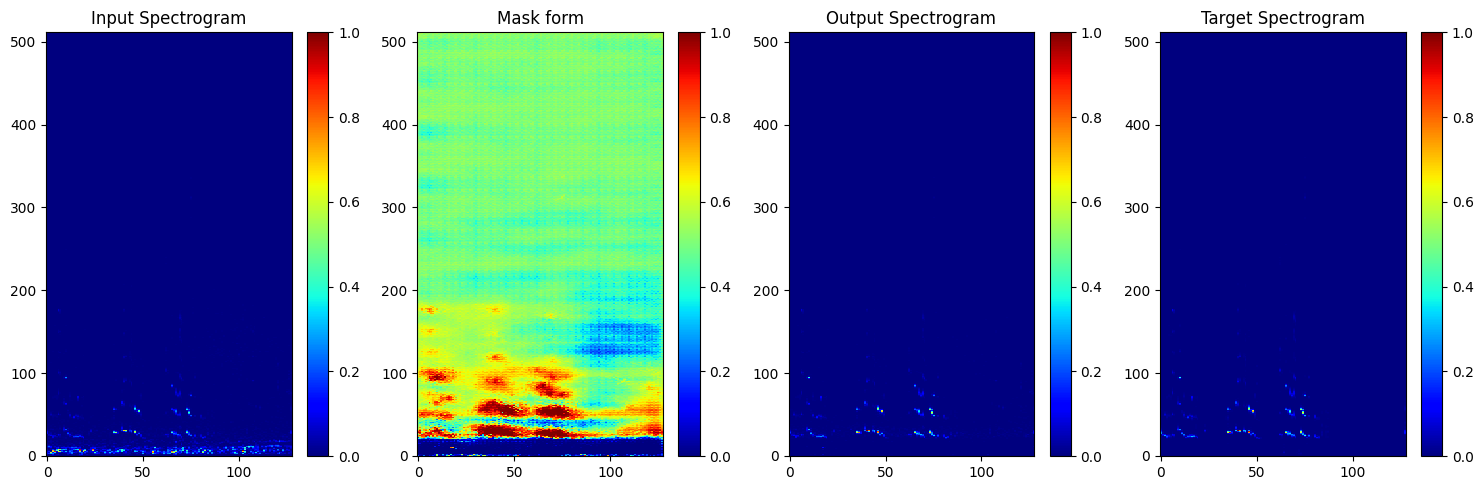

In [105]:
model = u_net_source_separation()
model.load_state_dict(torch.load('u_net_loss_2.pth',weights_only=True))
model.eval()  
sample = 'test/0002/mix_snr_-3.wav'
fe, data = scipy.io.wavfile.read(sample)
input_spectrogram = to_spectrogram(data, fe)
input_tensor = torch.tensor(input_spectrogram).unsqueeze(0).unsqueeze(0).float()

device = 'cpu'  
model.to(device)
input_tensor = input_tensor.to(device)
with torch.no_grad():  
    output = model(input_tensor)

mask = output.squeeze().cpu().numpy()
#maintenant, on peut multiplier le mask avec l'input

output_spectrogram = mask*input_spectrogram
output_spectrogram = (output_spectrogram-np.min(output_spectrogram))/(np.max(output_spectrogram)-np.min(output_spectrogram))
target_voice = 'test/0002/voice.wav'
fe,data = scipy.io.wavfile.read(target_voice)
target_spectrogram = to_spectrogram(data,fe)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(input_spectrogram, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Input Spectrogram')
plt.colorbar()

plt.subplot(1, 4, 2)
plt.imshow(mask, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Mask form')
plt.colorbar()

plt.subplot(1, 4, 3)
plt.imshow(output_spectrogram, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Output Spectrogram')
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(target_spectrogram, aspect='auto', origin='lower', cmap='jet', interpolation='none')
plt.title('Target Spectrogram')
plt.colorbar()

plt.tight_layout()
plt.show()


Le MSE moyen avec la loss L2 est : 0.06042437255382538
Le SDR moyen avec la loss L2 est : 9.914816856384277
Le NSDR moyen avec la loss L2 est : 9.263008117675781


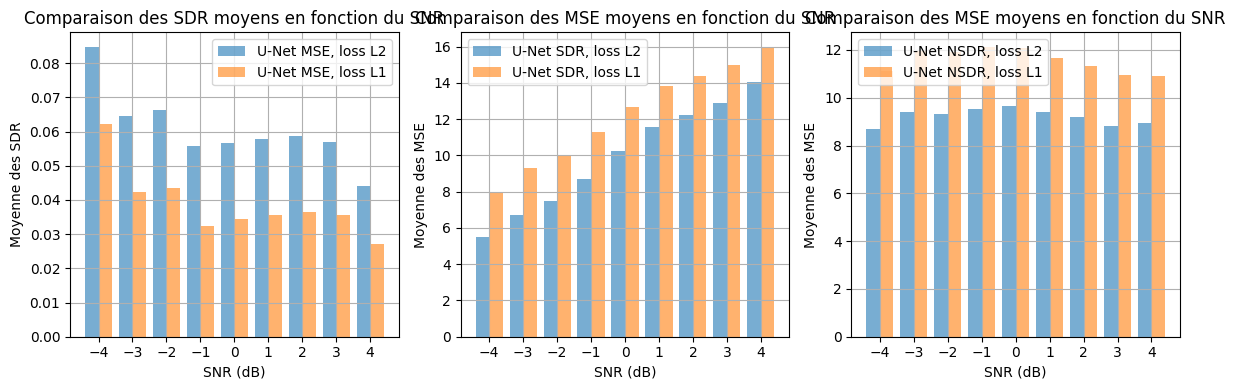

In [107]:
unet = u_net_source_separation()
unet.load_state_dict(torch.load('u_net_loss_2.pth',weights_only=True))


snr_values = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
snr_sdr_values_unet = {snr: [] for snr in snr_values}
snr_nsdr_values_unet = {snr:[] for snr in snr_values}
snr_mse_values_unet = {snr: [] for snr in snr_values}

sdr_mean = 0
nsdr_mean = 0
mse_mean = 0

for i in range(2000):
    if i < 10:
        folder_path = f'test/000{i}'
    elif i < 100:
        folder_path = f'test/00{i}'
    elif i < 1000:
        folder_path = f'test/0{i}'
    else:
        folder_path = f'test/{i}'
    
    # audio file
    fe1, data1 = scipy.io.wavfile.read(f'{folder_path}/voice.wav')
    file_path = glob(f'{folder_path}/mix_snr*')[0]
    fe2, data2 = scipy.io.wavfile.read(file_path)
    
    # extraire le SNR
    snr_match = re.search(r'mix_snr_(-?\d+)', file_path)
    if snr_match:
        snr = int(snr_match.group(1))
    
    data1 = data1[:64897]
    data2 = data2[:64897]
    
    target_spectrogram=to_spectrogram(data1,fe)
    input_spectrogram, phase, max_val, min_val = to_spectrogram_reconstruction(data2, fe2)
    input_tensor = torch.tensor(input_spectrogram).unsqueeze(0).unsqueeze(0).float()
    
    device = 'cpu'
    input_tensor = input_tensor.to(device)

    signal_target = masked_spectrogram_to_complex_spectrogram(
        target_spectrogram, phase, max_val, min_val, fe2
    )
    signal_mix = masked_spectrogram_to_complex_spectrogram(
        input_spectrogram, phase, max_val, min_val, fe2
    )

    unet.to(device)
    with torch.no_grad():
        output_unet = unet(input_tensor)

    mask_unet = output_unet.squeeze().cpu().numpy()
    spectrogram_unet = mask_unet * input_spectrogram
    signal_unet = masked_spectrogram_to_complex_spectrogram(
        spectrogram_unet, phase, max_val, min_val, fe2
    )
    sdr_unet = compute_sdr(signal_unet,signal_target)
    snr_nsdr_values_unet[snr].append(sdr_unet - compute_sdr(signal_mix,signal_target))
    snr_sdr_values_unet[snr].append(sdr_unet)
    snr_mse_values_unet[snr].append(mse(signal_unet,signal_target))
    mse_mean+=mse(signal_unet,signal_target)
    nsdr_mean += sdr_unet - compute_sdr(signal_mix,signal_target)
    sdr_mean += sdr_unet

print(f'Le MSE moyen avec la loss L2 est : {mse_mean/2000}')
print(f'Le SDR moyen avec la loss L2 est : {sdr_mean/2000}')
print(f'Le NSDR moyen avec la loss L2 est : {nsdr_mean/2000}')

unet_means_data= [np.mean(snr_sdr_values_unet[snr]) for snr in snr_values]
mse_unet_data= [np.mean(snr_mse_values_unet[snr]) for snr in snr_values]
unet_nsdr_data = [np.mean(snr_nsdr_values_unet[snr]) for snr in snr_values]

snr_values = np.array(snr_values)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].bar(snr_values - 0.2, mse_unet_data, width=0.4, label='U-Net MSE, loss L2', alpha=0.6, align='center')
axes[0].bar(snr_values+0.2, mse_unet, width=0.4, label='U-Net MSE, loss L1', alpha=0.6, align='center')
axes[0].set_xlabel('SNR (dB)')
axes[0].set_ylabel('Moyenne des SDR')
axes[0].set_title('Comparaison des SDR moyens en fonction du SNR')
axes[0].set_xticks(snr_values)
axes[0].legend()
axes[0].grid()

axes[1].bar(snr_values - 0.2, unet_means_data, width=0.4, label='U-Net SDR, loss L2', alpha=0.6, align='center')
axes[1].bar(snr_values + 0.2, unet_means, width=0.4, label='U-Net SDR, loss L1', alpha=0.6, align='center')
axes[1].set_xlabel('SNR (dB)')
axes[1].set_ylabel('Moyenne des MSE')
axes[1].set_title('Comparaison des MSE moyens en fonction du SNR')
axes[1].set_xticks(snr_values)
axes[1].legend()
axes[1].grid()

axes[2].bar(snr_values - 0.2, unet_nsdr_data, width=0.4, label='U-Net NSDR, loss L2', alpha=0.6, align='center')
axes[2].bar(snr_values + 0.2, unet_means_nsdr, width=0.4, label='U-Net NSDR, loss L1', alpha=0.6, align='center')
axes[2].set_xlabel('SNR (dB)')
axes[2].set_ylabel('Moyenne des MSE')
axes[2].set_title('Comparaison des MSE moyens en fonction du SNR')
axes[2].set_xticks(snr_values)
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()
